In [1]:
from sklearn.datasets import make_circles

n = 1000

X, y = make_circles(n, noise=0.05)
X[:5], y[:5]

(array([[-0.63120229,  0.45508678],
        [ 0.19926389, -1.02165603],
        [ 0.8238643 , -0.6558596 ],
        [-0.95177266,  0.47844826],
        [-1.00954298,  0.22823667]]), array([1, 0, 0, 0, 0]))

In [2]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2":X[:, 1], "label":y})
circles.head()

,X1,X2,label
0,-0.631202,0.455087,1
1,0.199264,-1.021656,0
2,0.823864,-0.655860,0
3,-0.951773,0.478448,0
4,-1.009543,0.228237,0


In [3]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

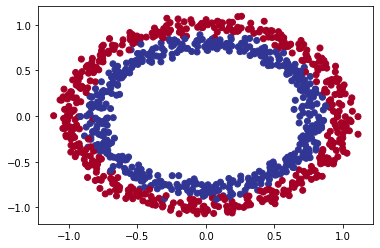

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
import torch

X = torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-0.6312,  0.4551],
         [ 0.1993, -1.0217],
         [ 0.8239, -0.6559],
         [-0.9518,  0.4784],
         [-1.0095,  0.2282]]), tensor([1., 0., 0., 0., 0.]))

In [7]:
X.dtype

torch.float32

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [9]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
model0 = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10,1)
).to(device)
model0

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
untrained_preds = model0(X_test.to(device))
untrained_preds.shape, y_test.shape

(torch.Size([200, 1]), torch.Size([200]))

In [12]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [13]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [14]:
y_logits = model0(X_test.to(device))
y_logits[:5]

tensor([[ 0.0947],
        [-0.0532],
        [ 0.0489],
        [ 0.0965],
        [ 0.0508]], device='cuda:0', grad_fn=<SliceBackward0>)

In [15]:
y_probs = torch.sigmoid(y_logits)
y_probs[:5]

tensor([[0.5236],
        [0.4867],
        [0.5122],
        [0.5241],
        [0.5127]], device='cuda:0', grad_fn=<SliceBackward0>)

In [16]:
y_preds = torch.round(y_probs)
y_preds[:5]

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SliceBackward0>)

In [17]:
epochs = 1000

X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

for epoch in range(1, 1+epochs):
    
    model0.train()

    train_logits = model0(X_train).squeeze()

    train_loss = loss_fn(train_logits, y_train)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if epoch%100==0:
        train_preds = torch.round(torch.sigmoid(train_logits))
        train_acc = accuracy(y_train, train_preds)

        model0.eval()
        with torch.inference_mode():
            test_logits = model0(X_test).squeeze()
            test_loss = loss_fn(test_logits, y_test)
            test_preds = torch.round(torch.sigmoid(test_logits))
            test_acc = accuracy(y_test, test_preds)

            print(f"Epoch: {epoch} Train Loss: {train_loss} Train Accuracy {train_acc} Test Loss {test_loss} Test Accuracy {test_acc}")

Epoch: 100 Train Loss: 0.6909387707710266 Train Accuracy 51.24999999999999 Test Loss 0.6887632012367249 Test Accuracy 53.5
Epoch: 200 Train Loss: 0.6886411309242249 Train Accuracy 61.625 Test Loss 0.6875141859054565 Test Accuracy 61.5
Epoch: 300 Train Loss: 0.684861421585083 Train Accuracy 58.875 Test Loss 0.6850014925003052 Test Accuracy 61.0
Epoch: 400 Train Loss: 0.677975058555603 Train Accuracy 59.5 Test Loss 0.6811609268188477 Test Accuracy 53.5
Epoch: 500 Train Loss: 0.6690347194671631 Train Accuracy 58.5 Test Loss 0.6767313480377197 Test Accuracy 53.0
Epoch: 600 Train Loss: 0.6556110978126526 Train Accuracy 61.0 Test Loss 0.6671217679977417 Test Accuracy 57.49999999999999
Epoch: 700 Train Loss: 0.6343526840209961 Train Accuracy 67.375 Test Loss 0.6459248065948486 Test Accuracy 63.0
Epoch: 800 Train Loss: 0.59356689453125 Train Accuracy 80.25 Test Loss 0.6034234166145325 Test Accuracy 78.5
Epoch: 900 Train Loss: 0.5181125402450562 Train Accuracy 90.875 Test Loss 0.523798942565918

In [18]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


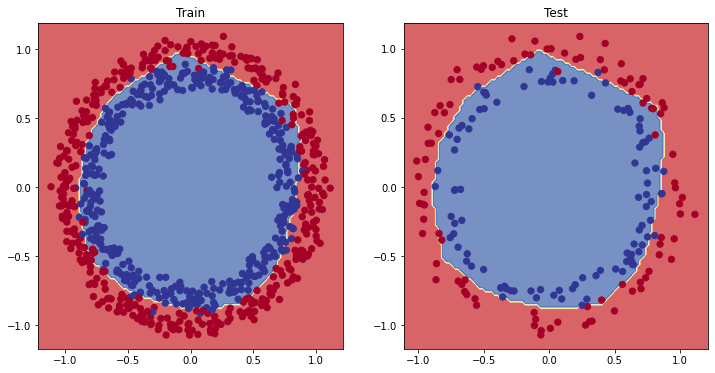

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)